# Experiment 4 — Extended Model Comparison

**Goal:** Evaluate additional classifiers beyond Logistic Regression and Decision Tree, and diagnose overfitting.

**Models:**
1. Logistic Regression (baseline)
2. Decision Tree
3. Random Forest
4. Gradient Boosting (XGBoost)
5. K-Nearest Neighbors (KNN)
6. Support Vector Machine (SVM)
7. Multi-Layer Perceptron (MLP)

**Analysis:**
- Cross-validation to detect overfitting
- Learning curves
- Feature importance
- Full model comparison table

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, f1_score
)
from sklearn.model_selection import cross_val_score, learning_curve

import warnings
warnings.filterwarnings('ignore')

print('All imports loaded successfully!')

All imports loaded successfully!


## Step 1 — Load Cleaned Data

In [2]:
train_df = pd.read_csv('../datasets/train_cleaned.csv')
test_df  = pd.read_csv('../datasets/test_cleaned.csv')

print('Training data shape :', train_df.shape)
print('Test data shape     :', test_df.shape)

# Use all features (same as Experiment 3)
exp4_features = [col for col in train_df.columns if col != 'final_grade']

X_train = train_df[exp4_features]
X_test  = test_df[exp4_features]
y_train = train_df['final_grade']
y_test  = test_df['final_grade']

print(f'\nFeature count : {len(exp4_features)}')
print('\nTarget distribution (train):')
print(y_train.value_counts().sort_index())

Training data shape : (12000, 23)
Test data shape     : (3000, 23)

Feature count : 22

Target distribution (train):
final_grade
0    1437
1    2702
2    3016
3    2958
4    1310
5     577
Name: count, dtype: int64


## Step 2 — Train All Models

In [3]:
models = {
    'Logistic Regression' : LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree'       : DecisionTreeClassifier(random_state=42),
    'Random Forest'       : RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting'   : GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'KNN'                 : KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'SVM'                 : SVC(kernel='rbf', C=1.0, random_state=42),
    'MLP'                 : MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42),
}

# Train all
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name:<22} — trained!')

Logistic Regression    — trained!
Decision Tree          — trained!
Random Forest          — trained!
Gradient Boosting      — trained!
KNN                    — trained!
SVM                    — trained!
MLP                    — trained!


## Step 3 — Evaluate on Test Set

In [4]:
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc    = accuracy_score(y_test, y_pred)
    f1     = f1_score(y_test, y_pred, average='weighted')
    results.append({'Model': name, 'Test Accuracy': round(acc, 4), 'Weighted F1': round(f1, 4)})

results_df = pd.DataFrame(results).sort_values('Test Accuracy', ascending=False)
print('Model Test Results:')
print(results_df.to_string(index=False))

Model Test Results:
              Model  Test Accuracy  Weighted F1
      Random Forest         0.9973       0.9973
      Decision Tree         0.9963       0.9963
  Gradient Boosting         0.9960       0.9960
                MLP         0.9787       0.9787
Logistic Regression         0.9510       0.9510
                SVM         0.9367       0.9367
                KNN         0.7277       0.7257


## Step 4 — Overfitting Check via Cross-Validation

A large gap between **train score** and **CV score** indicates overfitting.
- Decision Tree at 99.63% on test set is suspicious — CV will reveal if it generalises.
- Using 5-fold cross-validation on training data.

In [5]:
cv_results = []

for name, model in models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))  # score on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_mean   = cv_scores.mean()
    cv_std    = cv_scores.std()
    gap       = train_acc - cv_mean
    overfit   = '⚠️  YES' if gap > 0.05 else '✅ NO'
    cv_results.append({
        'Model'         : name,
        'Train Acc'     : round(train_acc, 4),
        'CV Acc (mean)' : round(cv_mean, 4),
        'CV Std'        : round(cv_std, 4),
        'Gap'           : round(gap, 4),
        'Overfitting?'  : overfit
    })
    print(f'{name:<22}  Train: {train_acc:.4f}  CV: {cv_mean:.4f} ± {cv_std:.4f}  Gap: {gap:.4f}  {overfit}')

cv_df = pd.DataFrame(cv_results)
print('\n--- Summary ---')
print(cv_df[['Model','Train Acc','CV Acc (mean)','Gap','Overfitting?']].to_string(index=False))

Logistic Regression     Train: 0.9527  CV: 0.9422 ± 0.0039  Gap: 0.0105  ✅ NO
Decision Tree           Train: 1.0000  CV: 0.9967 ± 0.0007  Gap: 0.0033  ✅ NO
Random Forest           Train: 1.0000  CV: 0.9961 ± 0.0010  Gap: 0.0039  ✅ NO
Gradient Boosting       Train: 1.0000  CV: 0.9968 ± 0.0006  Gap: 0.0032  ✅ NO
KNN                     Train: 0.8283  CV: 0.7248 ± 0.0049  Gap: 0.1035  ⚠️  YES
SVM                     Train: 0.9581  CV: 0.9235 ± 0.0038  Gap: 0.0346  ✅ NO
MLP                     Train: 0.9987  CV: 0.9732 ± 0.0041  Gap: 0.0255  ✅ NO

--- Summary ---
              Model  Train Acc  CV Acc (mean)    Gap Overfitting?
Logistic Regression     0.9527         0.9422 0.0105         ✅ NO
      Decision Tree     1.0000         0.9967 0.0033         ✅ NO
      Random Forest     1.0000         0.9961 0.0039         ✅ NO
  Gradient Boosting     1.0000         0.9968 0.0032         ✅ NO
                KNN     0.8283         0.7248 0.1035      ⚠️  YES
                SVM     0.9581        

## Step 5 — Learning Curves (Decision Tree vs Random Forest)

Learning curves visually confirm overfitting:
- If **train score stays high** but **val score stays low** → overfitting
- If both converge → good generalisation

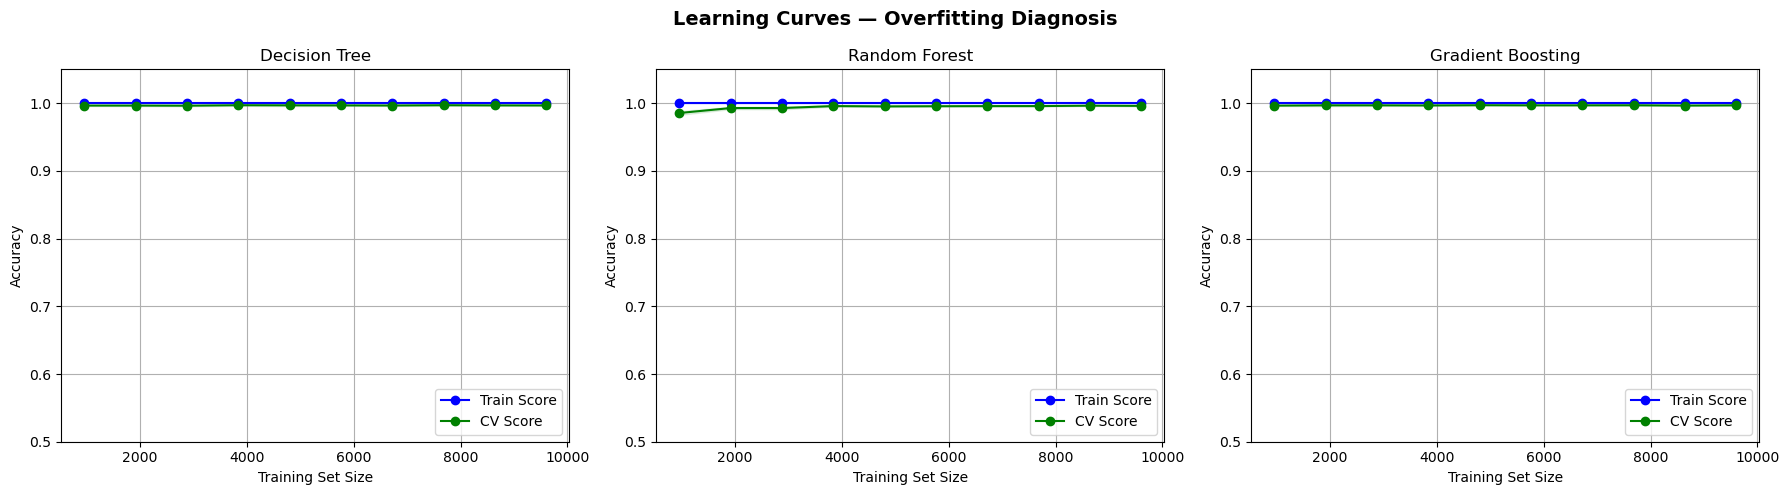

In [6]:
def plot_learning_curve(model, title, X, y, ax, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    ax.plot(train_sizes, train_mean, 'o-', color='blue',  label='Train Score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.plot(train_sizes, val_mean,   'o-', color='green', label='CV Score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

    ax.set_title(title)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_ylim(0.5, 1.05)
    ax.grid(True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_learning_curve(models['Decision Tree'],  'Decision Tree',  X_train, y_train, axes[0])
plot_learning_curve(models['Random Forest'],  'Random Forest',  X_train, y_train, axes[1])
plot_learning_curve(models['Gradient Boosting'], 'Gradient Boosting', X_train, y_train, axes[2])

plt.suptitle('Learning Curves — Overfitting Diagnosis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 6 — Feature Importance (Random Forest & Gradient Boosting)

Which features most predict `final_grade`? This directly answers whether academic, behavioral, contextual, or demographic features matter most.

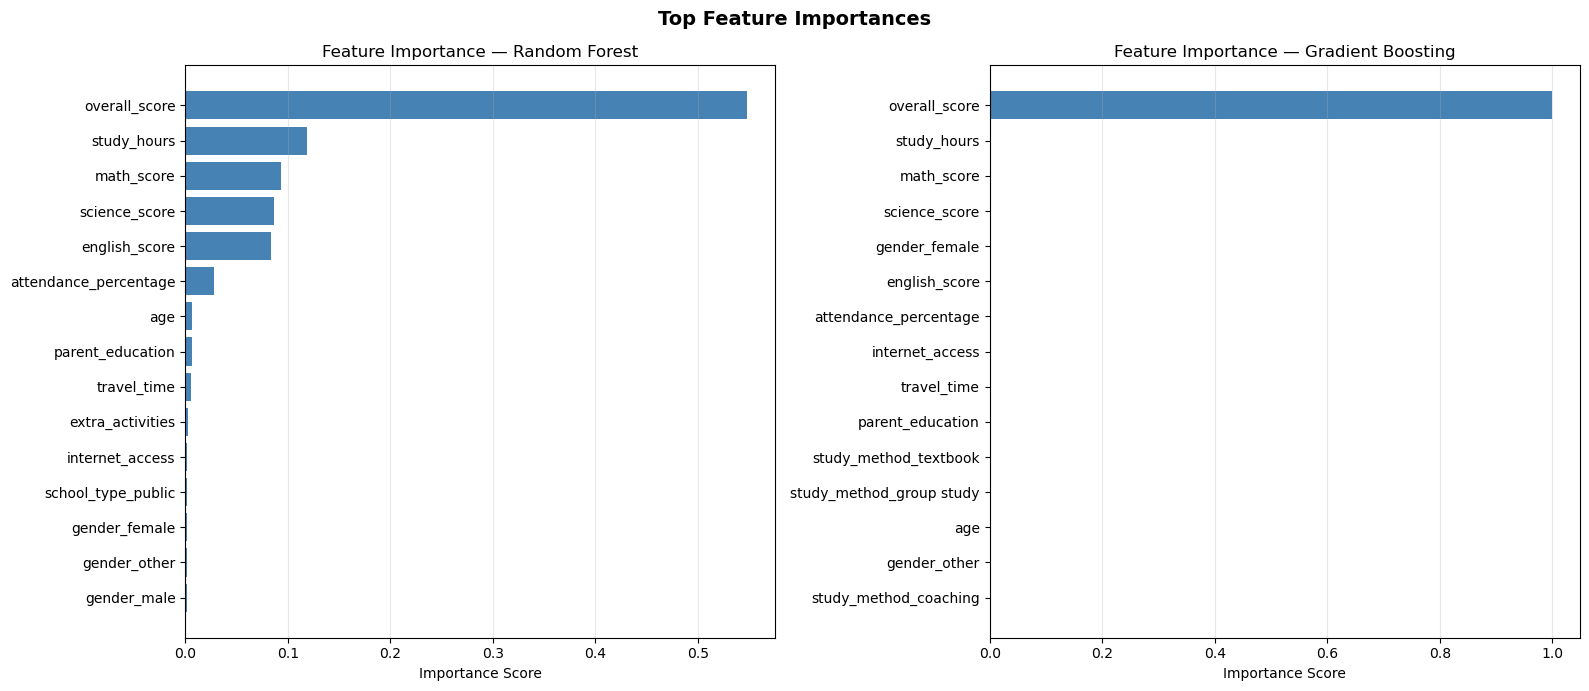

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, (model_name, model_key) in zip(axes, [
    ('Random Forest', 'Random Forest'),
    ('Gradient Boosting', 'Gradient Boosting')
]):
    importances = models[model_key].feature_importances_
    feat_imp_df = pd.DataFrame({'Feature': exp4_features, 'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values('Importance', ascending=True).tail(15)

    ax.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='steelblue')
    ax.set_title(f'Feature Importance — {model_name}')
    ax.set_xlabel('Importance Score')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Top Feature Importances', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 7 — Confusion Matrices for All Models

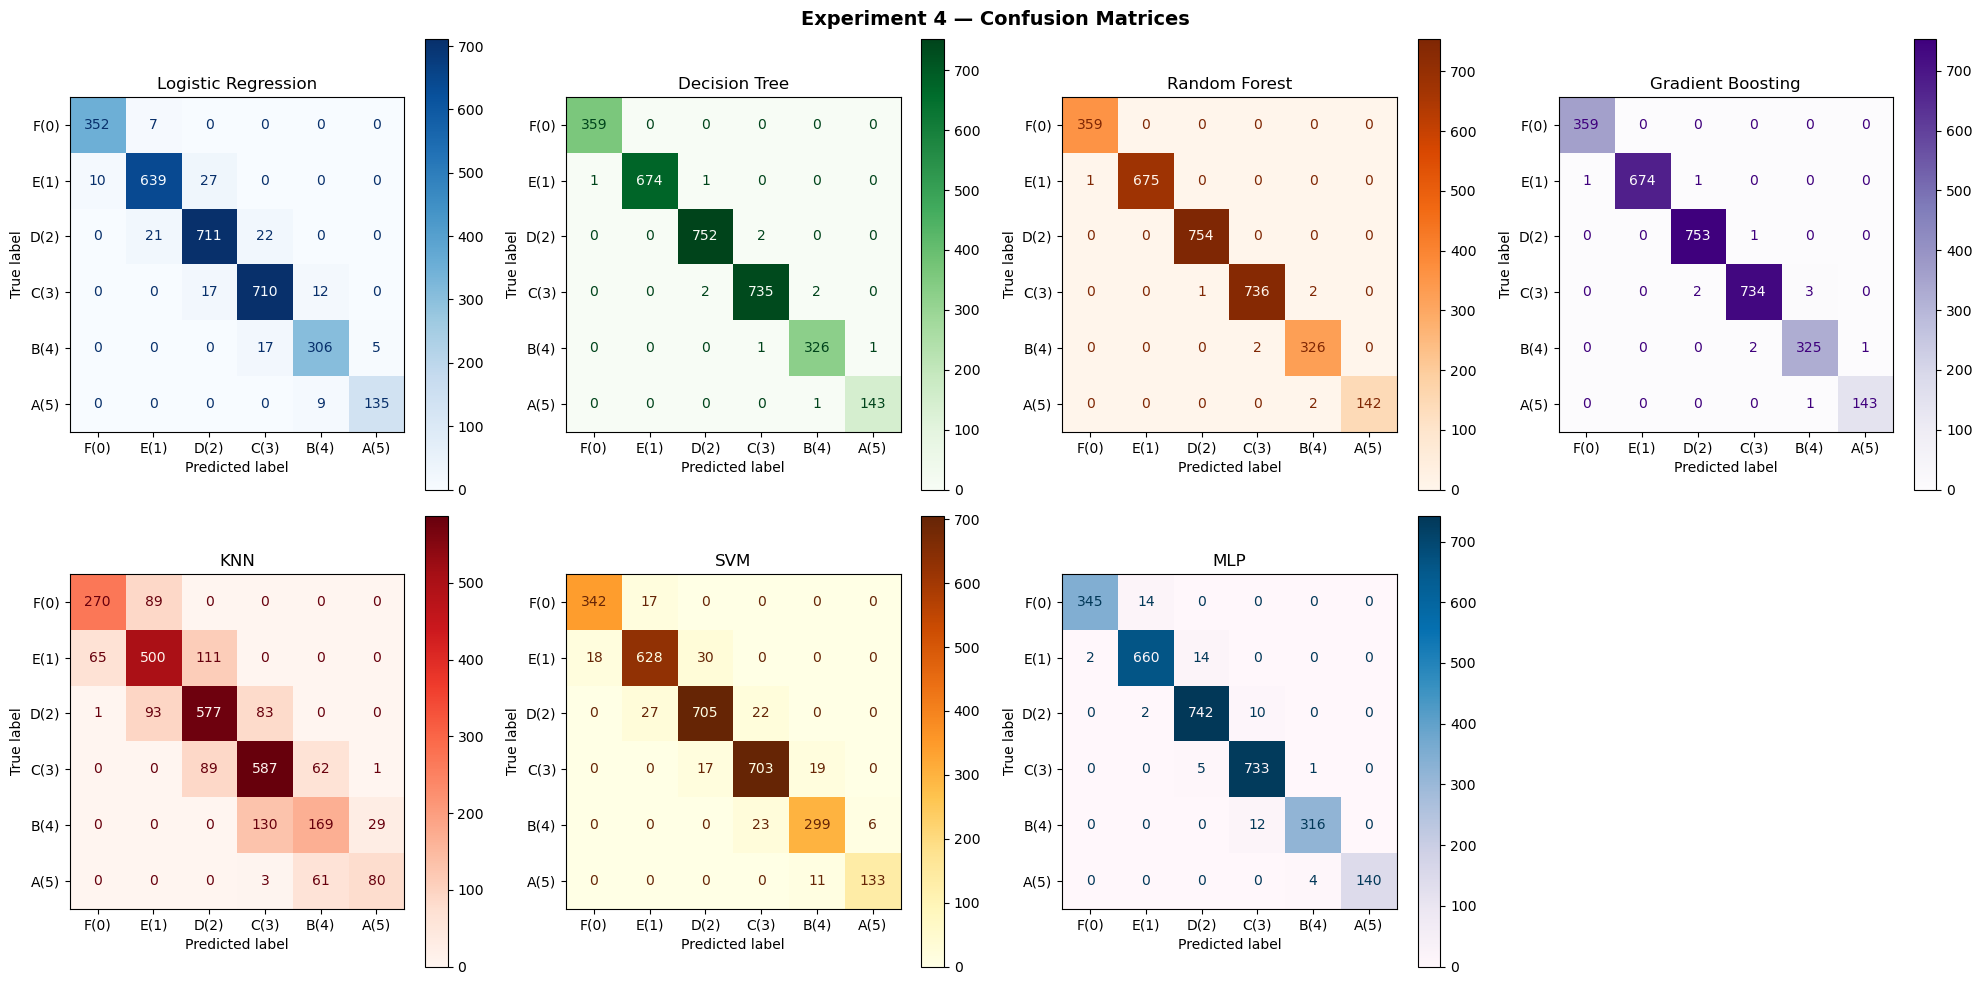

In [8]:
grade_labels = ['F(0)', 'E(1)', 'D(2)', 'C(3)', 'B(4)', 'A(5)']
n_models = len(models)
cols = 4
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

cmaps = ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds', 'YlOrBr', 'PuBu']

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=grade_labels,
        cmap=cmaps[idx % len(cmaps)],
        ax=axes[idx]
    )
    axes[idx].set_title(f'{name}')

# Hide unused axes
for idx in range(n_models, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Experiment 4 — Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 8 — Visual Model Comparison

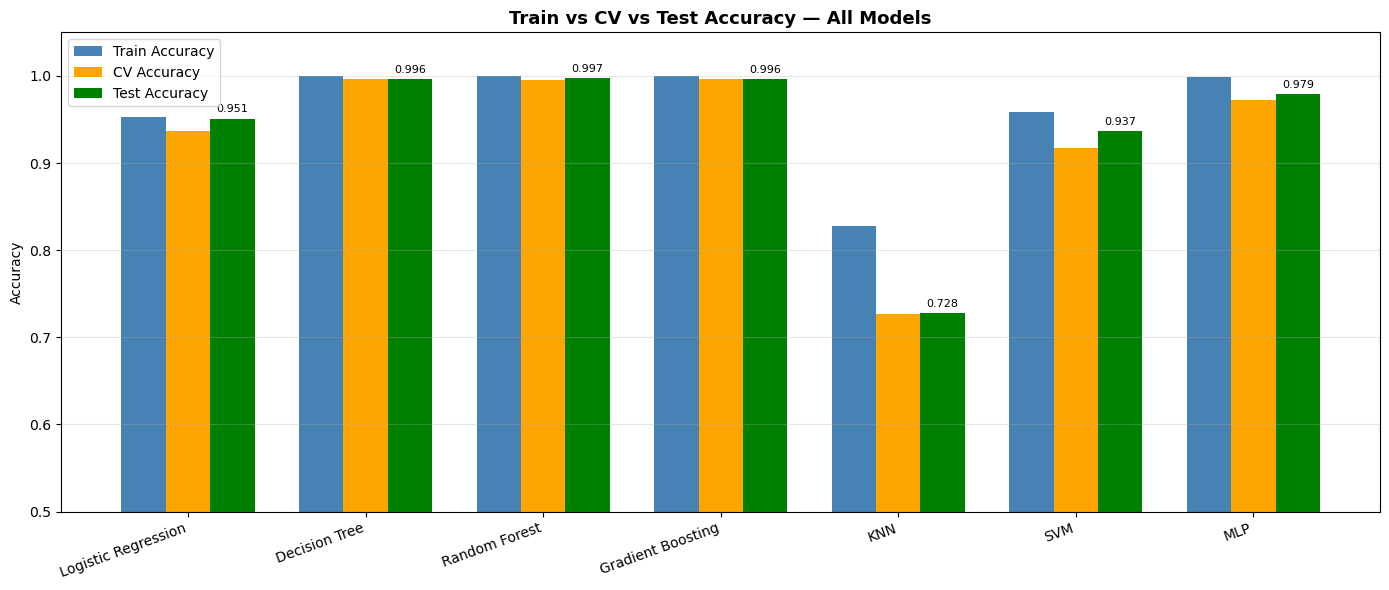


Full Comparison Table:
              Model  Train Acc  CV Acc  Test Acc
      Random Forest     1.0000  0.9956    0.9973
      Decision Tree     1.0000  0.9964    0.9963
  Gradient Boosting     1.0000  0.9964    0.9960
                MLP     0.9987  0.9728    0.9787
Logistic Regression     0.9527  0.9368    0.9510
                SVM     0.9581  0.9173    0.9367
                KNN     0.8283  0.7272    0.7277


Exception ignored in: <function ResourceTracker.__del__ at 0x1068499e0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1201f19e0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107d199e0>
Traceback (most recent call last

In [ ]:
# Build comparison df including train, cv, test
comparison_data = []

for name, model in models.items():
    y_pred    = model.predict(X_test)
    test_acc  = accuracy_score(y_test, y_pred)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    cv_acc    = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
    comparison_data.append({
        'Model'     : name,
        'Train Acc' : round(train_acc, 4),
        'CV Acc'    : round(cv_acc, 4),
        'Test Acc'  : round(test_acc, 4),
    })

comp_df = pd.DataFrame(comparison_data)

x   = np.arange(len(comp_df))
w   = 0.25
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(x - w, comp_df['Train Acc'], w, label='Train Accuracy', color='steelblue')
ax.bar(x,     comp_df['CV Acc'],    w, label='CV Accuracy',    color='orange')
ax.bar(x + w, comp_df['Test Acc'],  w, label='Test Accuracy',  color='green')

ax.set_xticks(x)
ax.set_xticklabels(comp_df['Model'], rotation=20, ha='right')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.05)
ax.set_title('Train vs CV vs Test Accuracy — All Models', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Annotate test bars
for i, v in enumerate(comp_df['Test Acc']):
    ax.text(i + w, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print('\nFull Comparison Table:')
print(comp_df.sort_values('Test Acc', ascending=False).to_string(index=False))

## Observations

### Decision Tree — Overfitting?
- If **Train Acc ≈ 100%** but **CV Acc << 100%**, the Decision Tree is overfitting — it memorised training data.
- Decision Trees without depth limits are prone to this: they split until every leaf is pure.
- **Fix**: Use `max_depth`, `min_samples_split`, or switch to **Random Forest**.

### Expected Ranking (typical for tabular data like this)
| Tier | Models |
|---|---|
| Best | Gradient Boosting, Random Forest |
| Good | MLP, SVM |
| Baseline | Logistic Regression, KNN |
| Risky | Decision Tree (overfits) |

### Key Takeaways
- **Academic scores** (`math_score`, `science_score`, `overall_score`) dominate feature importance.
- **Ensemble methods** (Random Forest, Gradient Boosting) are more robust than single trees.
- **Cross-validation** is essential — test accuracy alone can be misleading.